# Diffusion of Vector field in 2-D plane

The equation is given by,
$$
\partial_t \bar{V} = D \nabla^2 \bar{V}
$$
subjected to neumann boundary conditions.
The solution to this Equation is given by,
$$
\bar{V} = \sum_{n_x,n_y} \bar{V}_{0 (n_x,n_y)} cos(\pi n_x x/L + \pi n_y y/L) e^{-\frac{D \pi^2 (n_{x}^{2}+n_{y}^{2})t}{L^2}}
$$

In [89]:
# important libraries
from mpi4py import MPI
import dolfinx as dfx
import basix, ufl
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx import mesh
import numpy as np
import vtk
import pyvista as pv
from ufl import split
pv.set_jupyter_backend('trame')

In [90]:
dt=0.01
T = 5
nt = int(T/dt)
times = np.linspace(0, T, nt)
nx,ny = 32,32
#Diffusion const
D,n_x,n_y,vx,vy =0.1,1,0,1,0

In [91]:
# mesh

domain= mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, mesh.CellType.triangle)

# geometrical and topological dimension
gdim, tdim = domain.geometry.dim, domain.topology.dim
x = domain.geometry.x[:]
print(x,gdim,tdim)

[[0.96875 0.      0.     ]
 [1.      0.      0.     ]
 [1.      0.03125 0.     ]
 ...
 [0.      0.96875 0.     ]
 [0.03125 1.      0.     ]
 [0.      1.      0.     ]] 2 2


In [92]:
# Defining scalar, vector and tensor elements

scalar_element = basix.ufl.element("P", domain.basix_cell(), 1)
vector_element = basix.ufl.element("P", domain.basix_cell(), 2, shape=(gdim,))
tensor_element = basix.ufl.element("P", domain.basix_cell(),2, shape=(gdim,gdim))

In [93]:
SFS = dfx.fem.functionspace(domain,scalar_element)
VFS = dfx.fem.functionspace(domain,vector_element)
TFS = dfx.fem.functionspace(domain,tensor_element)

In [94]:
V = dfx.fem.Function(VFS)
V_old = dfx.fem.Function(VFS)
v = ufl.TestFunction(VFS)

## Exact solution

The exact solution is given by,
$$
\bar{V} = \sum_{n_x,n_y} \bar{V}_{0 (n_x,n_y)} cos(n_x x + n_y y) e^{-\frac{D \pi^2 (n_{x}^{2}+n_{y}^{2})t}{L^2}}
$$

In [106]:
def ex1(x,tt):
    v_x = vx*np.cos(np.pi*n_x*x[0])*np.cos(np.pi*n_y*x[1])*np.exp(-D*(np.pi**2) *(n_x**2+n_y**2)*tt*dt)
    v_y = vy*np.cos(np.pi*n_x*x[0])*np.cos(np.pi*n_y*x[1])*np.exp(-D*(np.pi**2) *(n_x**2+n_y**2)*tt*dt)
    return np.array([v_x,v_y])

In [107]:
# initial velocity
u_initial = dfx.fem.Function(VFS)
dof_coords = VFS.tabulate_dof_coordinates() # Note: In parallel, this returns the local coordinates.
n_v = dof_coords.shape[0]
print(dof_coords[0])
values = np.empty(u_initial.x.array.shape, dtype=np.float64)

u_initial.interpolate(lambda x:ex1(x,tt=0))
V_old.interpolate(lambda x:ex1(x,tt=0))

[ 9.68750000e-01 -6.73196272e-19  0.00000000e+00]


## Ploting Initial field

In [108]:

u_vals = u_initial.x.array
ar1 =np.zeros(len(u_vals))
ar2 =np.zeros(len(u_vals))
for i in range(0,int(len(u_vals)/2)-1):
    ar1[i] = u_vals[2*i]
    ar2[i] = u_vals[2*i+1]
u_vals_reshaped = np.column_stack((
    ar1[0:n_v],
    ar2[0:n_v]
    #u_vals[2*n_v:3*n_v]
))

points = domain.geometry.x  # N x gdim array - n points in 3 d space
#Identify the correct VTK cell type (e.g., VTK_TRIANGLE = 5, VTK_TETRA = 10, etc.) and construct a PyVista
conn = domain.topology.connectivity(tdim, 0).array
#print(conn)
num_cells = len(conn) // 4  # for number of triangles
cell_array = []
# Suppose tdim=2 and you have triangles
# Build the "cells" array: [3, i0, i1, i2, 3, j0, j1, j2, ...]
for c in range(num_cells):
    cell_array.append(3)
    cell_array.extend(conn[3*c : 3*c + 3])
#For VTK/PyVista unstructured grids, each cell’s connectivity must start with the number of points in that cell, followed by the actual indices. 
# For triangles, there are 3 points per cell, so we append the number 3 each time.
cell_array = np.array(cell_array, dtype=np.int32)
cell_types = np.full(num_cells, 5, dtype=np.uint8)   
# 5 is VTK_TRIANGLE
# points is domain.geometry.x

grid = pv.UnstructuredGrid(cell_array, cell_types, points)
plotter = pv.Plotter()
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
vgrid = pv.UnstructuredGrid(topology, cell_types, positions)
print(vgrid)
topology, cell_types, positions = dfx.plot.vtk_mesh(SFS)
sgrid = pv.UnstructuredGrid(topology, cell_types, positions)
print(sgrid)


vector_scale, vector_color = 0.1, 'black'

pl = pv.Plotter()

# plot vectors

# The 'orient' parameter tells PyVista which array holds the vector directions.
zeros = np.zeros(n_v)
u_vals_3d = np.column_stack((u_vals_reshaped, zeros))
vgrid.point_data['gradu'] = u_vals_3d
arrows = vgrid.glyph(orient="gradu", scale="gradu", factor=0.1)

# --- Plotting with PyVista ---

# Create a plotter.
plotter = pv.Plotter()

# Add the sphere surface as an opaque object.
plotter.add_mesh(vgrid, color='lightgray', opacity=1, show_edges=False)

# Overlay the glyphs (arrows) on the sphere.
plotter.add_mesh(arrows, color='black', label='initial velocity')

plotter.add_legend()
plotter.show()

UnstructuredGrid (0x70cbf004ca60)
  N Cells:    2048
  N Points:   4225
  X Bounds:   -6.732e-19, 1.000e+00
  Y Bounds:   -6.732e-19, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   0
UnstructuredGrid (0x70cc4c83ae00)
  N Cells:    2048
  N Points:   1089
  X Bounds:   -6.732e-19, 1.000e+00
  Y Bounds:   -6.732e-19, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   0


Widget(value='<iframe src="http://localhost:35173/index.html?ui=P_0x70cbc801c190_38&reconnect=auto" class="pyv…

We now need to write down the weak form of,
$$
\partial_t V_a  = D \nabla^2 V_a
$$
So we have
$$
f = \frac{1}{dt} <V-V_{old},v> + D<\nabla V, \nabla v>
$$

In [109]:
form = ufl.inner((1/dt)*(V-V_old),v)*ufl.dx + D*ufl.inner(ufl.grad(V),ufl.grad(v))*ufl.dx
problem = NonlinearProblem(form, V, bcs=[])
solver  = NewtonSolver(MPI.COMM_WORLD, problem)

In [110]:

V_ex = dfx.fem.Function(VFS)
V_ex.interpolate(lambda x: ex1(x,tt=0))     


In [111]:
V_array =np.zeros((nt, len(V_old.x.array)))
V_exact = np.zeros((nt, len(V_old.x.array)))
V_array[0] = V_old.x.array
V_exact[0] = V_ex.x.array 

err_array = np.zeros( nt)
L2_error = dfx.fem.form(ufl.inner( V_old - V_ex, V_old - V_ex) * ufl.dx)
error_local = dfx.fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
err_array[0] = error_L2 

for tt in range(1,nt,1):
    solver.solve(V)
    V_ex.interpolate(lambda x: ex1(x,tt))
    V_exact[tt] = V_ex.x.array
    V_array[tt] = V.x.array
    #V_old.x.array[:] = V_ex.x.array
    V_old.x.array[:] = V.x.array
    L2_error = dfx.fem.form(ufl.inner( V - V_ex,  V - V_ex) * ufl.dx)
    error_local = dfx.fem.assemble_scalar(L2_error)
    error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
    err_array[tt]=error_L2
    

## Error Plot

Text(0.5, 0, 'time')

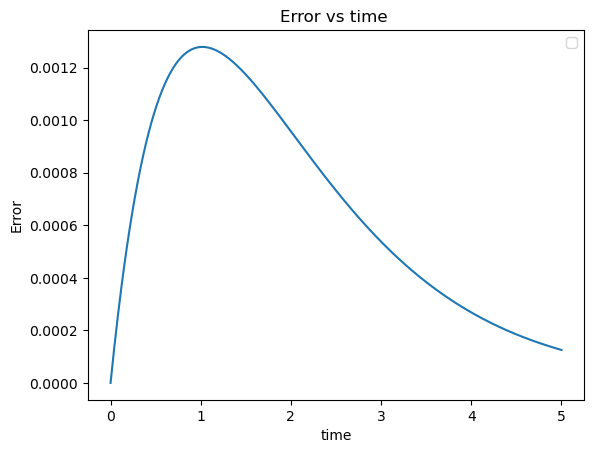

In [112]:
import matplotlib.pyplot as plt
plt.plot(times, err_array)
plt.legend()
plt.title("Error vs time ")
plt.ylabel("Error")
plt.xlabel("time")

## Plotting Numerical Solution

In [113]:
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
vgrid = pv.UnstructuredGrid(topology, cell_types, positions)


cmap, n_colors = 'coolwarm', 11
vector_scale, vector_color = 0.1, 'black'


pl = pv.Plotter()

#plot scalars
scalar_bar_args={'title':r'u', 'n_labels':3,
                'fmt':'%3.1f', 'vertical':True, 
                'height':0.5, 'width':0.05}

# plot vectors
u_vals = V_array[0]
ar1 =np.zeros(len(u_vals))
ar2 =np.zeros(len(u_vals))
for i in range(0,int(len(u_vals)/2)-1):
    ar1[i] = u_vals[2*i]
    ar2[i] = u_vals[2*i+1]
u_vals_reshaped = np.column_stack((
    ar1[0:n_v],
    ar2[0:n_v]
    #u_vals[2*n_v:3*n_v]
))
zeros = np.zeros(n_v)
u_vals_3d = np.column_stack((u_vals_reshaped, zeros))
vgrid.point_data['gradu'] = u_vals_3d
arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
vgrid.set_active_vectors('gradu')
arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
def update(idx):
    global vmesh
    pl.remove_actor(vmesh)
    
    u_vals = V_array[idx]
    ar1 =np.zeros(len(u_vals))
    ar2 =np.zeros(len(u_vals))
    for i in range(0,int(len(u_vals)/2)-1):
        ar1[i] = u_vals[2*i]
        ar2[i] = u_vals[2*i+1]
    u_vals_reshaped = np.column_stack((
        ar1[0:n_v],
        ar2[0:n_v]
        #u_vals[2*n_v:3*n_v]
    ))
    zeros = np.zeros(n_v)
    u_vals_3d = np.column_stack((u_vals_reshaped, zeros))
    vgrid.point_data['gradu'] = u_vals_3d
    arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
    vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
    vgrid.set_active_vectors('gradu')
    arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
    vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
    
    


def slider_update(value):
    idx = (abs(times-value)).argmin()
    update(idx)
    return

slider = pl.add_slider_widget(slider_update, 
                                rng=[times.min(), times.max()], value=times.min(), 
                                title=r'αt', style='modern',
                                interaction_event='always',
                                pointa=(0.35, 0.1), pointb=(0.75, 0.1), 
                                slider_width=0.03, tube_width=0.03,
                                fmt='%3.1f')

pl.show()

Widget(value='<iframe src="http://localhost:35173/index.html?ui=P_0x70cba7fa4a50_39&reconnect=auto" class="pyv…

## Plotting Exact solution

In [114]:
topology, cell_types, positions = dfx.plot.vtk_mesh(VFS)
vgrid = pv.UnstructuredGrid(topology, cell_types, positions)


cmap, n_colors = 'coolwarm', 11
vector_scale, vector_color = 0.1, 'black'


pl = pv.Plotter()

#plot scalars
scalar_bar_args={'title':r'u', 'n_labels':3,
                'fmt':'%3.1f', 'vertical':True, 
                'height':0.5, 'width':0.05}

# plot vectors
u_vals = V_array[0]
ar1 =np.zeros(len(u_vals))
ar2 =np.zeros(len(u_vals))
for i in range(0,int(len(u_vals)/2)-1):
    ar1[i] = u_vals[2*i]
    ar2[i] = u_vals[2*i+1]
u_vals_reshaped = np.column_stack((
    ar1[0:n_v],
    ar2[0:n_v]
    #u_vals[2*n_v:3*n_v]
))
zeros = np.zeros(n_v)
u_vals_3d = np.column_stack((u_vals_reshaped, zeros))
vgrid.point_data['gradu'] = u_vals_3d
arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
vgrid.set_active_vectors('gradu')
arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
def update(idx):
    global vmesh
    pl.remove_actor(vmesh)
    
    u_vals = V_exact[idx]
    ar1 =np.zeros(len(u_vals))
    ar2 =np.zeros(len(u_vals))
    for i in range(0,int(len(u_vals)/2)-1):
        ar1[i] = u_vals[2*i]
        ar2[i] = u_vals[2*i+1]
    u_vals_reshaped = np.column_stack((
        ar1[0:n_v],
        ar2[0:n_v]
        #u_vals[2*n_v:3*n_v]
    ))
    zeros = np.zeros(n_v)
    u_vals_3d = np.column_stack((u_vals_reshaped, zeros))
    vgrid.point_data['gradu'] = u_vals_3d
    arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
    vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
    vgrid.set_active_vectors('gradu')
    arrows = vgrid.glyph(orient='gradu', scale=True, factor=vector_scale)
    vmesh = pl.add_mesh(arrows, color=vector_color, name='gradu')
    
    


def slider_update(value):
    idx = (abs(times-value)).argmin()
    update(idx)
    return

slider = pl.add_slider_widget(slider_update, 
                                rng=[times.min(), times.max()], value=times.min(), 
                                title=r'αt', style='modern',
                                interaction_event='always',
                                pointa=(0.35, 0.1), pointb=(0.75, 0.1), 
                                slider_width=0.03, tube_width=0.03,
                                fmt='%3.1f')

pl.show()

Widget(value='<iframe src="http://localhost:35173/index.html?ui=P_0x70cba7f83110_40&reconnect=auto" class="pyv…